# Deep dive on price feature engeering with LightGBM

- To reduce bias, select the data in Manhattan from 2012-2019.
- Using logistic regression to get the block is the most significant fator to price.

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_excel("Manhattan - 2012 - 2019.xlsx",skiprows = 1)

In [3]:
new_df = df.iloc[:,[2,4,5,11,12,13,14,15,19]]

In [4]:
new_df.head()

,BUILDING CLASS CATEGORY\n,BLOCK\n,LOT\n,RESIDENTIAL UNITS\n,COMMERCIAL UNITS\n,TOTAL UNITS\n,LAND SQUARE FEET\n,GROSS SQUARE FEET\n,SALE PRICE\n
0,03 THREE FAMILY HOMES,377,10,3.0,0.0,3.0,1804.0,2928.0,0
1,07 RENTALS - WALKUP APARTMENTS,375,62,20.0,0.0,20.0,2426.0,9345.0,3650000
2,07 RENTALS - WALKUP APARTMENTS,376,30,13.0,0.0,13.0,2726.0,13002.0,895250
3,07 RENTALS - WALKUP APARTMENTS,377,52,5.0,0.0,5.0,2169.0,3728.0,0
4,07 RENTALS - WALKUP APARTMENTS,387,157,40.0,0.0,40.0,4853.0,25200.0,10800000


# Machine Learning to identify key factor of lower price

In [5]:
new_df.rename(columns={'BUILDING CLASS CATEGORY\n':'CATEGORY','BLOCK\n':'block','LOT\n':'lot',
                  'RESIDENTIAL UNITS\n':'re-unit','COMMERCIAL UNITS\n':'co-unit','TOTAL UNITS\n':'to-unit',
                  'LAND SQUARE FEET\n':'land_sq','GROSS SQUARE FEET\n':'gross_sq','SALE PRICE\n':'SALE_PRICE'}, inplace=True)

In [6]:
new_df = new_df[new_df['gross_sq'].between(1,600000)]
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31080 entries, 0 to 176992
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CATEGORY    31080 non-null  object 
 1   block       31080 non-null  int64  
 2   lot         31080 non-null  int64  
 3   re-unit     31080 non-null  float64
 4   co-unit     31080 non-null  float64
 5   to-unit     31080 non-null  float64
 6   land_sq     31080 non-null  float64
 7   gross_sq    31080 non-null  float64
 8   SALE_PRICE  31080 non-null  int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 2.4+ MB


In [7]:
encoder = LabelEncoder()
new_df['CATEGORY'] = encoder.fit_transform(new_df['CATEGORY'])

In [8]:
categorical_feature = ['CATEGORY']
target = 'SALE_PRICE'

new_df[categorical_feature] = new_df[categorical_feature].astype('int')
new_df[target] = new_df[target].astype('int')

In [9]:
X = new_df.drop('SALE_PRICE', axis=1)
y = new_df['SALE_PRICE']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [10]:
d_train = lgb.Dataset(data=X_train, label=y_train, categorical_feature=None, free_raw_data=False)

In [11]:
params = {'learning_rate': 0.01, 
          'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'metric': ['binary_logloss', 'auc'], 
          'sub_feature':0.5, 
          'num_leaves': 31, 
          'min_data': 50, 
          'max_depth': 4, 
          'is_unbalance': True}

history = lgb.cv(params, train_set=d_train, num_boost_round=1000, 
                 early_stopping_rounds=20, seed=42, verbose_eval=False)

print('Best rounds:\t', len(history['auc-mean']))

[LightGBM] [Info] Number of positive: 10413, number of negative: 6245
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1502
[LightGBM] [Info] Number of data points in the train set: 16658, number of used features: 8
[LightGBM] [Info] Number of positive: 10412, number of negative: 6246
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1502
[LightGBM] [Info] Number of data points in the train set: 16658, number of used features: 8
[LightGBM] [Info] Number of positive: 10412, number of negative: 6246
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_col_wise=true` to 

In [12]:
clf = lgb.train(params, train_set=d_train, num_boost_round=52)
pred = clf.predict(X_test)

[LightGBM] [Info] Number of positive: 13016, number of negative: 7807
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1502
[LightGBM] [Info] Number of data points in the train set: 20823, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.625078 -> initscore=0.511159
[LightGBM] [Info] Start training from score 0.511159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

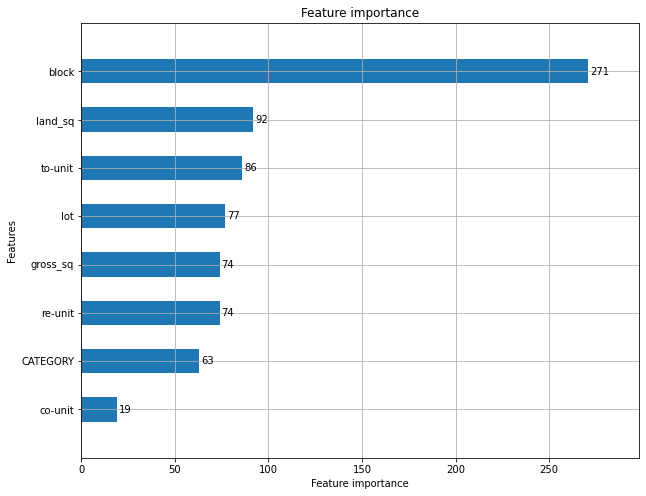

In [13]:
features = clf.feature_name()
importance = clf.feature_importance()

fig, ax = plt.subplots(figsize=(10, 8))
lgb.plot_importance(clf, ax=ax, height=0.5)
plt.show()

# End